In [1]:
import pickle as pkl
import pandas as pd
from tqdm import tqdm
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

In [3]:
ROOT = 'C:\\Users\\curea\\Documents\\bioFM for drug discovery\\dege-fm\\'

with open(ROOT + "results\\baseline\\zhao_predictions.pkl", 'rb') as f:
    output_model = pkl.load(f)

In [5]:
targets = list()
predicted = list()
input = list()
meta = list()

for x in tqdm(output_model):

    assert x['targets'].shape == x['predicted'].shape

    for i in range(x['targets'].shape[0]):
        targets.append(x['targets'][i].cpu().numpy())

    for i in range(x['predicted'].shape[0]):
        predicted.append(x['predicted'][i].cpu().numpy())

    for i in range(x['input'].shape[0]):
        input.append(x['input'][i].cpu().numpy()[:1280])

    compound_list = x['meta']['compound']
    dose_list = x['meta']['dose'].tolist()

    for i in range(len(compound_list)):
        meta.append(compound_list[i] + "_" + str(dose_list[i]))


df_targets = pd.DataFrame(targets)
df_predicted = pd.DataFrame(predicted)
df_input = pd.DataFrame(input)

df_targets['data_type'] = "target"
df_predicted['data_type'] = "predicted"
df_input['data_type'] = "input"

df_targets['condition'] = meta
df_predicted['condition'] = meta
df_input['condition'] = meta

del meta

df = pd.concat([df_targets, df_predicted, df_input], axis=0, ignore_index=True)

del df_targets
del df_predicted
del df_input

X = df.iloc[:, :1280].values
obs = df[['condition', 'data_type']]

del df

adata = ad.AnnData(X=X, obs=obs)

del X
del obs



100%|██████████| 605/605 [00:07<00:00, 76.68it/s]
C:\Users\curea\anaconda3\envs\dege-fm\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
adata

AnnData object with n_obs × n_vars = 232305 × 1280
    obs: 'condition', 'data_type'

In [7]:
def plot_css(adata):
    """
    Compare r-squared values between the null model and predictions
        ** compare r-squared between control-target and predicted-target pairs **
    TODO: this assumes that the order of pairs is preserved
    """
    css_model = list()
    css_null = list()


    for condition in tqdm(list(adata.obs['condition'].unique())):
        adata_subset = adata[adata.obs['condition'] == condition]

        X_control = adata_subset[adata_subset.obs['data_type'] == "input"].X
        X_target = adata_subset[adata_subset.obs['data_type'] == "target"].X
        X_predicted = adata_subset[adata_subset.obs['data_type'] == "predicted"].X


        for i in range(X_control.shape[0]):
            x_control = X_control[i,]
            x_target = X_target[i,]
            x_predicted = X_predicted[i,]


            cosine_similarity_model = np.dot(x_target, x_predicted) / (np.linalg.norm(x_target) * np.linalg.norm(x_predicted))

            cosine_similarity_null = np.dot(x_target, x_control) / (np.linalg.norm(x_target) * np.linalg.norm(x_control))

            css_model.append(cosine_similarity_model)
            css_null.append(cosine_similarity_null)

    data = pd.DataFrame({
        "css": css_model + css_null,
        "model": ["model"] * len(css_model) + ["null"] * len(css_null)
    })

    plt.figure(figsize=(8, 6))  # Set the figure size
    sns.boxplot(x='model', y='css', data=data)  # Create the boxplot
    plt.xlabel('Predictor')  # X-axis label
    plt.ylabel('CSS')  # Y-axis label
    plt.show()  # Show the plot



100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


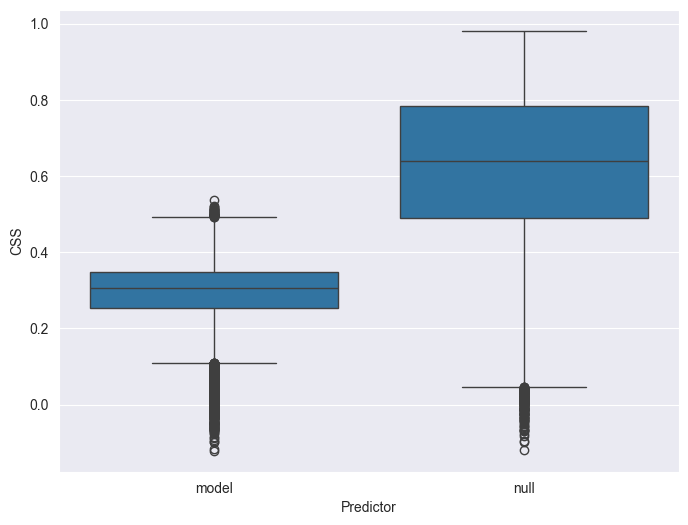

In [8]:
plot_css(adata)

In [9]:
def plot_mse(adata):
    """
    Compare r-squared values between the null model and predictions
        ** compare r-squared between control-target and predicted-target pairs **
    TODO: this assumes that the order of pairs is preserved
    """
    mse_model_list = list()
    mse_null_list = list()


    for condition in tqdm(list(adata.obs['condition'].unique())):
        adata_subset = adata[adata.obs['condition'] == condition]

        X_control = adata_subset[adata_subset.obs['data_type'] == "input"].X
        X_target = adata_subset[adata_subset.obs['data_type'] == "target"].X
        X_predicted = adata_subset[adata_subset.obs['data_type'] == "predicted"].X


        for i in range(X_control.shape[0]):
            x_control = X_control[i,]
            x_target = X_target[i,]
            x_predicted = X_predicted[i,]


            mse_model = np.mean((x_target - x_predicted) ** 2)

            mse_null = np.mean((x_target - x_control) ** 2)

            mse_model_list.append(mse_model)
            mse_null_list.append(mse_null)

    data = pd.DataFrame({
        "mse": mse_model_list + mse_null_list,
        "model": ["model"] * len(mse_model_list) + ["null"] * len(mse_null_list)
    })

    plt.figure(figsize=(8, 6))  # Set the figure size
    sns.boxplot(x='model', y='mse', data=data)  # Create the boxplot
    plt.xlabel('Predictor')  # X-axis label
    plt.ylabel('MSE')  # Y-axis label
    plt.show()  # Show the plot



100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


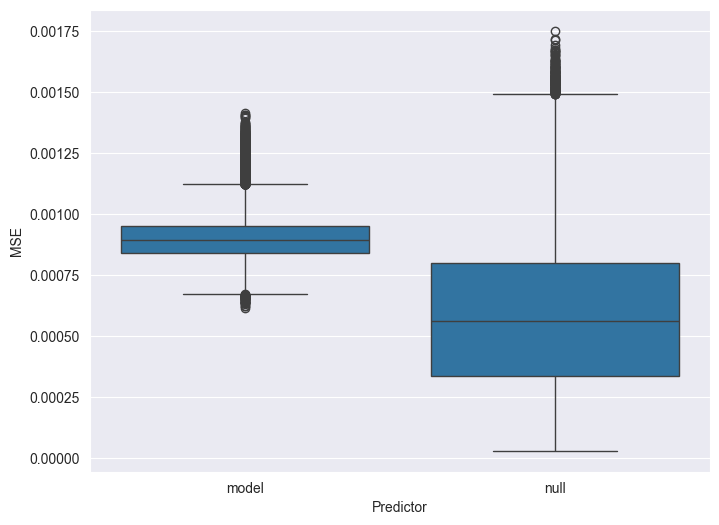

In [10]:
plot_mse(adata)

In [11]:
def plot_r2(adata):
    """
    Compare R-squared values between the null model and predictions.
    """
    r2_model_list = list()
    r2_null_list = list()

    for condition in tqdm(list(adata.obs['condition'].unique())):
        adata_subset = adata[adata.obs['condition'] == condition]

        X_control = adata_subset[adata_subset.obs['data_type'] == "input"].X
        X_target = adata_subset[adata_subset.obs['data_type'] == "target"].X
        X_predicted = adata_subset[adata_subset.obs['data_type'] == "predicted"].X

        for i in range(X_control.shape[0]):
            x_control = X_control[i,]
            x_target = X_target[i,]
            x_predicted = X_predicted[i,]

            # Compute SS_tot and SS_res for model and null
            ss_tot = np.sum((x_target - np.mean(x_target)) ** 2)
            ss_res_model = np.sum((x_target - x_predicted) ** 2)
            ss_res_null = np.sum((x_target - x_control) ** 2)

            # Compute R-squared
            r2_model = 1 - (ss_res_model / ss_tot)
            r2_null = 1 - (ss_res_null / ss_tot)

            r2_model_list.append(r2_model)
            r2_null_list.append(r2_null)

    # Prepare data for plotting
    data = pd.DataFrame({
        "R-squared": r2_model_list + r2_null_list,
        "model": ["model"] * len(r2_model_list) + ["null"] * len(r2_null_list)
    })

    # Plot
    plt.figure(figsize=(8, 6))  # Set the figure size
    sns.boxplot(x='model', y='R-squared', data=data)  # Create the boxplot
    plt.xlabel('Predictor')  # X-axis label
    plt.ylabel('R-squared')  # Y-axis label
    plt.title('Comparison of R-squared Values')  # Title
    plt.show()  # Show the plot

100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


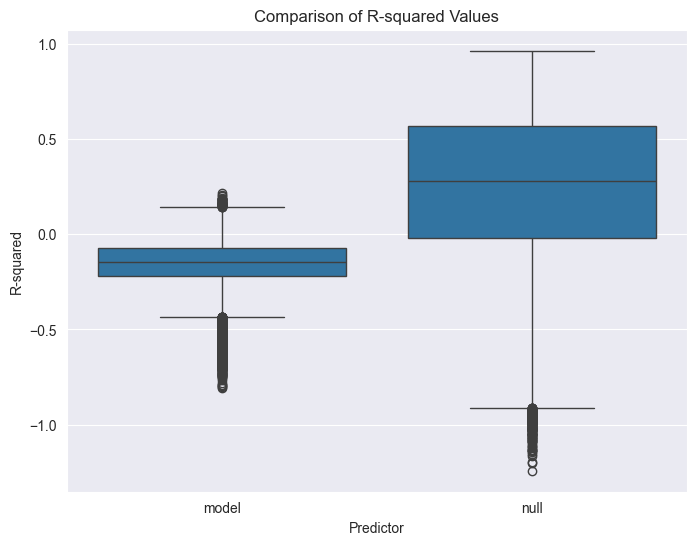

In [12]:
plot_r2(adata)